## Import Libraries 

In [1]:
import warnings
import sys
sys.path.insert(0, '../../src')
warnings.filterwarnings('ignore')

In [2]:
import ABC_train_test
import friedman3Dataset
import network
import dataset
import sanityChecks
import performanceMetrics
import torch 
import numpy as np 
from torch.utils.data import random_split 
import scrapbook as sb
from statistics import mean 
import statsModel
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.tab_model import TabNetRegressor

## Parameters
ABC-Generator parameters are as mentioned below: 
1. mean : 1 ($\beta \sim N(\beta^{*},\sigma)$ where $\beta^{*}$ are coefficients of statistical model) or 1 ($\beta \sim N(0,\sigma)$
2. std : $\sigma = 1, 0.1 , 0.01$ (standard deviation)

In [3]:
#ABC Generator Parameters
abc_mean = 1
variance = 1
bias = 1 
#Training parameters 
n_epochs = 1000

In [4]:
# Parameters
variance = 0.01
bias = 0.01


## Dataset

In [5]:
#Parameters 
n_features = 4
n_samples= 100
n_target = 1

In [6]:
X, Y = friedman3Dataset.friedman3_data(n_samples)
# Train test split for dataset 
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2)
train_data = dataset.CustomDataset(X_train,Y_train)
test_data = dataset.CustomDataset(X_test,Y_test)

          X1           X2        X3        X4         Y
0  59.432260  1134.265511  0.516805  9.872634  1.525750
1  53.427863   844.993010  0.614490  9.103228  1.288397
2  28.514700   334.580650  0.104089  9.567493  0.848267
3  92.064818   963.822950  0.649751  4.249841  1.308577
4  34.811498  1425.123592  0.462056  3.701028  1.704846


## Training Parameters 



In [7]:
batch_size = 32
#Select the device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### MSE Threshold and Mean Coeff Values 

Fetch coefficient values from stats model to be used in the ABC pre-generator 

Fetch MSE threshold for training the ABC-GAN 

The ABC-GAN will be trained until the threshold MSE is achieved or until it completes 5000 epochs 

The threshold mse is the mean mse of Catboost over 10 runs

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.609
Model:                            OLS   Adj. R-squared (uncentered):              0.589
Method:                 Least Squares   F-statistic:                              29.63
Date:                Wed, 27 Jul 2022   Prob (F-statistic):                    7.49e-15
Time:                        10:43:08   Log-Likelihood:                         -76.042
No. Observations:                  80   AIC:                                      160.1
Df Residuals:                      76   BIC:                                      169.6
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

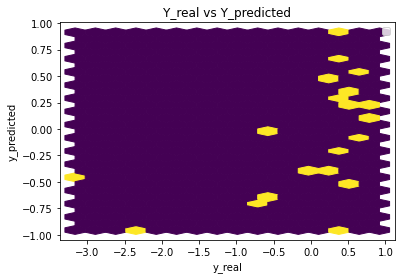

Performance Metrics
Mean Squared Error: 0.7525135603905991
Mean Absolute Error: 0.6151844867064253
Manhattan distance: 12.303689734128506
Euclidean distance: 3.8794679026655166


Prior Model MAE 0.6151844867064253


Prior Model MAE 0.6144072785860699


In [8]:
coeff , y_pred =statsModel.statsModel(X_train,Y_train,X_test,Y_test)
y_abc = y_pred + np.random.normal(0,variance, y_pred.shape) + bias 
mse = mean_squared_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mse)
mse = mean_squared_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mse)

mae = mean_absolute_error(y_pred,Y_test)
sb.glue("Prior Model MSE",mae)
print("Prior Model MAE",mae)
mae = mean_absolute_error(y_abc,Y_test)
sb.glue("ABC Pre-generator MSE",mae)
print("Prior Model MAE",mae)

# ABC GAN 

In [9]:
gen = network.Generator(n_features+1).to(device)
disc = network.DiscriminatorTabnet(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc.parameters(), lr=0.01, betas=(0.5, 0.999))

In [10]:
#Training the ABC_GAN 
discLossA1,genLossA1 = ABC_train_test.training_GAN(disc, gen,disc_opt,gen_opt,train_data,batch_size,n_epochs,criterion,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_1 Generator Loss",genLossA1)
sb.glue("ABC_GAN_1 Discriminator Loss",discLossA1)

In [11]:
ABC_GAN1_metrics=ABC_train_test.test_generator(gen,test_data,coeff,abc_mean,variance,bias,device)
sb.glue("ABC_GAN_1 Metrics",ABC_GAN1_metrics)
#print("ABC_GAN_1 Metrics",ABC_GAN1_metrics)
print('MAE:', mean(ABC_GAN1_metrics[1]))

MAE: 2928.759523221706


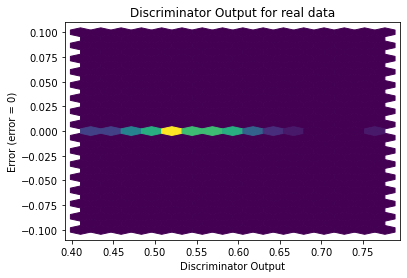

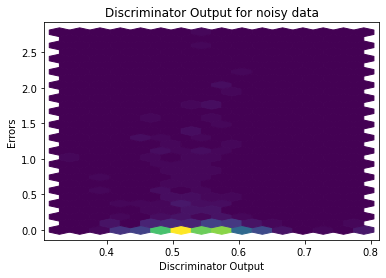

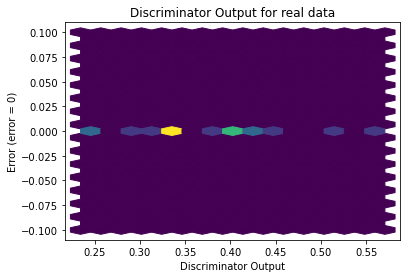

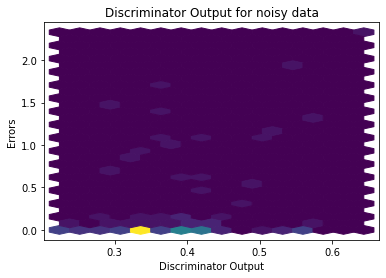

In [12]:
sanityChecks.discProbVsError(train_data,disc,device)
sanityChecks.discProbVsError(test_data,disc,device)

# ABC - GAN Model with skip connection

In [13]:
#Generator
gen3 = network.GeneratorWithSkipConnection(n_features+1).to(device)
#Discriminator 
disc3 = network.DiscriminatorTabnet(n_features+1).to(device)

criterion = torch.nn.BCELoss()
gen_opt = torch.optim.Adam(gen3.parameters(), lr=0.01, betas=(0.5, 0.999))
disc_opt = torch.optim.Adam(disc3.parameters(), lr=0.01, betas=(0.5, 0.999))


In [14]:
discLossA3,genLossA3 = ABC_train_test.training_GAN_skip_connection(disc3, gen3,disc_opt,gen_opt,train_data,batch_size, n_epochs,criterion,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_3 Generator Loss",genLossA3)
sb.glue("ABC_GAN_3 Discriminator Loss",discLossA3)

In [15]:
ABC_GAN3_metrics=ABC_train_test.test_generator(gen3,test_data,coeff,abc_mean,variance,bias,device)

sb.glue("ABC_GAN_3 Metrics",ABC_GAN3_metrics)
print("MAE:", mean(ABC_GAN3_metrics[1]))

MAE: 2168.207137184237


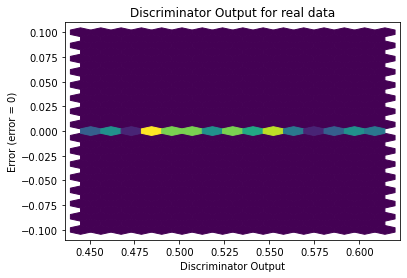

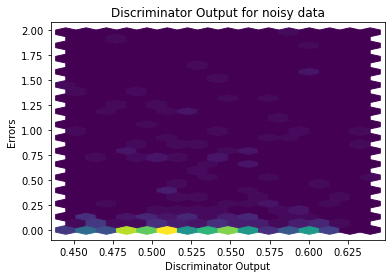

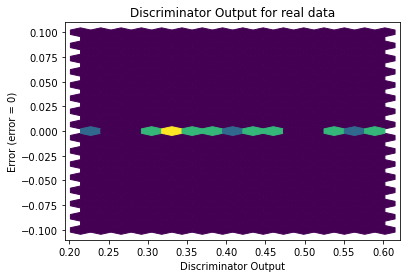

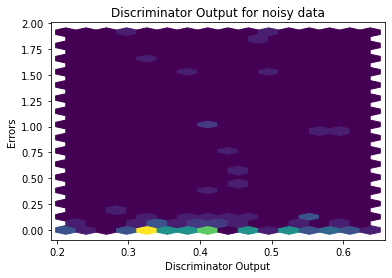

In [16]:
sanityChecks.discProbVsError(train_data,disc3,device)
sanityChecks.discProbVsError(test_data,disc3,device)

## Skip Connection Model Analysis - ABC-GAN 

### Weight Analysis 

Study the weights of the skip connection layer

Equation of the skip connection is 

$output = y_{gan} * w + y_{abc} * (1-w)$

In [17]:
print("Weight of the node at skip connection")
for name,param in gen3.named_parameters():
    if(name == "skipNode.weight"):
        print(param)
        sb.glue("Skip Connection Weight",param.item())
        print("Skip Connection Weight",param.item())

Weight of the node at skip connection
Parameter containing:
tensor([[0.0266]], requires_grad=True)


Skip Connection Weight 0.02660832181572914


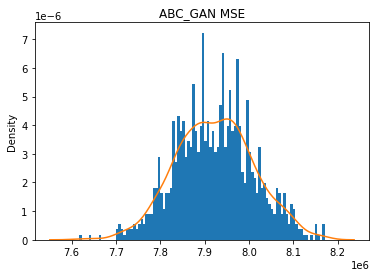

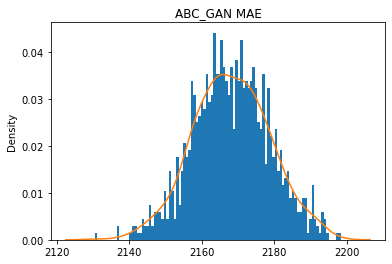

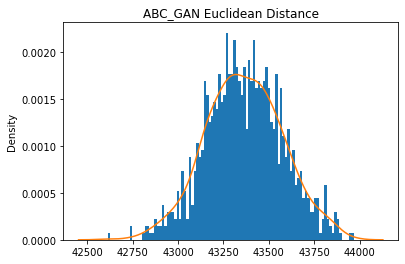

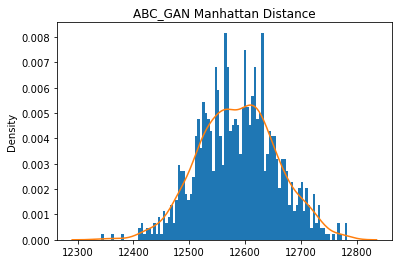

In [18]:
performanceMetrics.modelAnalysis2(ABC_GAN3_metrics)